In [1]:
import os

# Change this relative to your own directory structure
PARENT_DIR = '/Users/henrygilbert/GitHub/phd_chatgpt'
os.chdir(PARENT_DIR)

In [5]:
from dotenv import load_dotenv
import mlflow
import numpy as np
import pandas as pd
from typing import List, Dict
import logging
import json
import scipy as scp
from enum import Enum
from chatgpt_util import ChatGPTUtil
import mlflow_utils
from sklearn.decomposition import PCA

# for creating a responsive plot  
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2

load_dotenv('secrets.env')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

In [ ]:
mlflow.set_experiment("Experiment 1")
mlflow.end_run()
mlflow.start_run()

In [3]:
class Prompt(Enum):
    ONE = "How large is the earth?"  # Purposefully vague question with the metric for large not being specified
    TWO = "How many grams are in a kilogram?"   # Specific question with specific answer
    THREE = "How many grams does the average dinner plate that is 12 inches in diameter weigh?" # Abstract question with abstract answer
    FOUR = "What is your definition of love?" # Specific question with more abstract answer
    FIVE = "If there are 5 apples and 3 oranges in a basket, how many fruits are in the basket?" # Specific question with specific answer
    SIX = "What is the underlying, unknown probability distribution that drives economic markets?" # Abstract question with abstract answer

mlflow.log_params({f'prompt_{i}': prompt.value for i, prompt in enumerate(Prompt)})


In [ ]:
prompt_to_response: Dict[str, List[str]] = {}
num_samples = 100
max_tokens = 100

mlflow.log_param('num_samples', num_samples)
mlflow.log_param('max_tokens', max_tokens)

for prompt_idx, prompt in enumerate(Prompt):
    responses = ChatGPTUtil.get_text_response(
        prompt=prompt.value,
        samples=num_samples,
        max_tokens=max_tokens)
    prompt_to_response[prompt.value] = responses

mlflow_utils.log_dict_artifact(prompt_to_response, 'prompt_to_response')

In [ ]:
response_to_embedding = {}
for prompt, responses in prompt_to_response.items():
    print(f'Prompt: {prompt}')
    for i, response in enumerate(responses):
        print(f"        response {i}") if i % 10 == 0 else None
        embedding = ChatGPTUtil.get_text_embedding(response)
        response_to_embedding[response] = embedding
mlflow_utils.log_dict_artifact(response_to_embedding, 'response_to_embedding')

In [ ]:
response_to_embedding = mlflow_utils.load_dict_artifact('response_to_embedding')
prompt_to_response = mlflow_utils.load_dict_artifact('prompt_to_response')
response_to_embedding = {k: np.array(v) for k, v in response_to_embedding.items()}

In [ ]:
prompt_to_embeddings = {}
for prompt, responses in prompt_to_response.items():
    embeddings = [response_to_embedding[response] for response in responses]
    prompt_to_embeddings[prompt] = embeddings

In [ ]:
prompt_to_reduced_embeddings = {}
for prompt in prompt_to_embeddings.keys():
    
    embeddings_mean = np.mean(prompt_to_embeddings[prompt], axis=0)
    embeddings_cov = np.cov(prompt_to_embeddings[prompt], rowvar=False)
   
    mutlivariant_normal = scp.stats.multivariate_normal(
        mean=embeddings_mean, 
        cov=embeddings_cov,
        allow_singular=True) # Cov is singular due to limited data
    entropy = mutlivariant_normal.entropy()
    print(f"prompt: {prompt} - entropy: {entropy}")
    
    prompt_name = Prompt(prompt).name
    mlflow_utils.save_np_array_artifact(embeddings_mean, f'{prompt_name}_mean')
    mlflow_utils.save_np_array_artifact(embeddings_cov, f'{prompt_name}_cov')
    mlflow.log_metric(f'{prompt_name}_entropy', entropy)
    
    # PCA
    pca = PCA(n_components=3)
    transformed_values = pca.fit_transform(prompt_to_embeddings[prompt])
    mlflow_utils.save_np_array_artifact(transformed_values, f'{prompt_name}_transformed_values')
    
    pca_components = pca.components_
    mlflow_utils.save_np_array_artifact(pca_components, f'{prompt_name}_pca_components')
    
    pca_explained_variance = pca.explained_variance_
    mlflow_utils.save_np_array_artifact(pca_explained_variance, f'{prompt_name}_pca_explained_variance')
    
    pca_explained_variance_ratio = pca.explained_variance_ratio_
    mlflow_utils.save_np_array_artifact(pca_explained_variance_ratio, f'{prompt_name}_pca_explained_variance_ratio')
    
    pca_mean = pca.mean_
    mlflow_utils.save_np_array_artifact(pca_mean, f'{prompt_name}_pca_mean')
    
    pca_noise_variance = pca.noise_variance_
    mlflow_utils.save_np_array_artifact(pca_noise_variance, f'{prompt_name}_pca_noise_variance')
    
    pca_n_components = pca.n_components_
    mlflow.log_metric(f'{prompt_name}_pca_n_components', pca_n_components)
    
    pca_n_features = pca.n_features_
    mlflow.log_metric(f'{prompt_name}_pca_n_features', pca_n_features)
    
    pca_n_samples = pca.n_samples_
    mlflow.log_metric(f'{prompt_name}_pca_n_samples', pca_n_samples)
    
    pca_singular_values = pca.singular_values_
    mlflow_utils.save_np_array_artifact(pca_singular_values, f'{prompt_name}_pca_singular_values')
    
    prompt_to_reduced_embeddings[prompt] = transformed_values



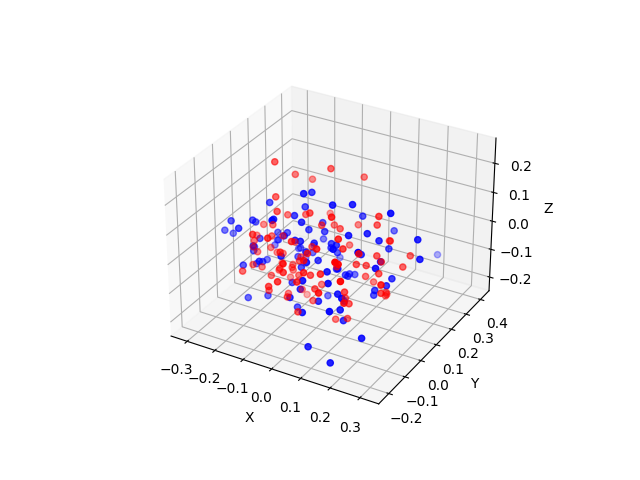

In [21]:
ONE_reduced_embeddings = mlflow_utils.load_np_array_artifact('ONE_transformed_values')
TWO_reduced_embeddings = mlflow_utils.load_np_array_artifact('TWO_transformed_values')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

xs_one = ONE_reduced_embeddings[:, 0]
ys_one = ONE_reduced_embeddings[:, 1]
zs_one = ONE_reduced_embeddings[:, 2]

xs_two = TWO_reduced_embeddings[:, 0]
ys_two = TWO_reduced_embeddings[:, 1]
zs_two = TWO_reduced_embeddings[:, 2]

# img = ax.scatter(xs_one, ys_one, zs_one, cmap=plt.hot(), c='r')
# fig.colorbar(img)
ax.scatter(xs_one, ys_one, zs_one, cmap=plt.hot(), c='r')
ax.scatter(xs_two, ys_two, zs_two, cmap=plt.hot(), c='b')
# Add second data plots onto same graph
 

# img = ax.scatter(xs_two, ys_two, zs_two, cmap=plt.hot(), c='g')
# fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()